In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.optim

# CODE FILES HERE
from examples.vae.vae import Encoder, Decoder, Vae, PATH
from solver import Solver
from dataloader import DataLoader
from plot import plot_losses, plot_gaussian_distributions, plot_rl_kl, plot_latent_space, plot_latent_space_no_labels, \
plot_latent_manifold, plot_faces_grid, plot_faces_samples_grid

%matplotlib inline
#plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [3]:
batch_size = 128
optimizer = torch.optim.Adam

In [6]:
# Choose the dataset and tune hyperparameters here!
dataset = "FF"

if dataset == "MNIST" or dataset == "EMNIST":
    epochs = 16
    hidden_dim = 500 # Kingma, Welling use 500 neurons, otherwise use 400
    z_dim = 2
    step_config = {
        "step_size" : -1,
        "gamma" : 0.1
    }
    optim_config = {
        "lr": 1e-3,
        "weight_decay": 0
    }
elif dataset == "LFW":
    epochs = 200
    hidden_dim = 700 # 200 in Kingma for Frey Face but we have highly varying data!
    z_dim = 2
    step_config = {
        "step_size" : 50,
        "gamma" : 0.1
    }
    optim_config = {
        "lr": 1e-2,
        "weight_decay": 1e-4
    }
elif dataset == "FF":
    epochs = 40 # 200 for zdim=20, 500 for zdim=2
    hidden_dim = 200 # as in Kingma
    z_dim = 2
    step_config = {
        "step_size" : 100,
        "gamma" : 0.1
    }
    optim_config = {
        "lr": 1e-3,
        "weight_decay": 0
    }

In [7]:
data_loader = DataLoader(PATH, batch_size, dataset, z_dim)
encoder = Encoder(data_loader.input_dim, hidden_dim, z_dim)
decoder = Decoder(z_dim, hidden_dim, data_loader.input_dim)
model = Vae(encoder, decoder)

In [8]:
solver = Solver(model, data_loader, optimizer, z_dim, epochs, step_config, optim_config)
solver.run()

+++++ START RUN +++++
====> Epoch: 1 train set loss avg: 376.1338
====> Test set loss avg: 359.6104
0.4344751834869385 seconds for epoch 1
====> Epoch: 2 train set loss avg: 356.9603
====> Test set loss avg: 357.0006
0.36505675315856934 seconds for epoch 2
====> Epoch: 3 train set loss avg: 354.4466
====> Test set loss avg: 355.5461
0.35733604431152344 seconds for epoch 3
====> Epoch: 4 train set loss avg: 353.8585
====> Test set loss avg: 355.2906
0.4639286994934082 seconds for epoch 4
====> Epoch: 5 train set loss avg: 353.4277
====> Test set loss avg: 355.1893
0.3859443664550781 seconds for epoch 5
====> Epoch: 6 train set loss avg: 353.2369
====> Test set loss avg: 354.8066
0.36272287368774414 seconds for epoch 6
====> Epoch: 7 train set loss avg: 352.9478
====> Test set loss avg: 354.3554
0.35089635848999023 seconds for epoch 7
====> Epoch: 8 train set loss avg: 352.7365
====> Test set loss avg: 354.1239
0.4443061351776123 seconds for epoch 8
====> Epoch: 9 train set loss avg: 352

In [ ]:
# Insert name of model here if want to load a model, e.g. "../models/VAE_MNIST_train_loss=151.39_z=2.pt"
#solver = torch.load()
#solver.model.eval()

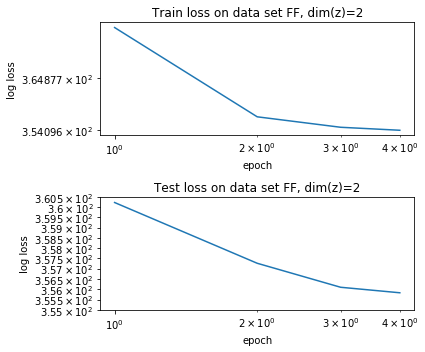

In [93]:
# Plotting train and test losses for all epochs
plot_losses(solver)

epoch: 1, mu(z): -0.3931, stddev(z): 0.9398, var(z): 0.8833, var(mu(z)): 0.0012 E[var(q(z|x)]: 0.2209
epoch: 12, mu(z): -0.1527, stddev(z): 0.7312, var(z): 0.5347, var(mu(z)): 0.1045 E[var(q(z|x)]: 0.2302
epoch: 24, mu(z): 0.0284, stddev(z): 0.9623, var(z): 0.9259, var(mu(z)): 0.4511 E[var(q(z|x)]: 0.3478
epoch: 40, mu(z): 0.0426, stddev(z): 1.0080, var(z): 1.0161, var(mu(z)): 0.8492 E[var(q(z|x)]: 0.0400


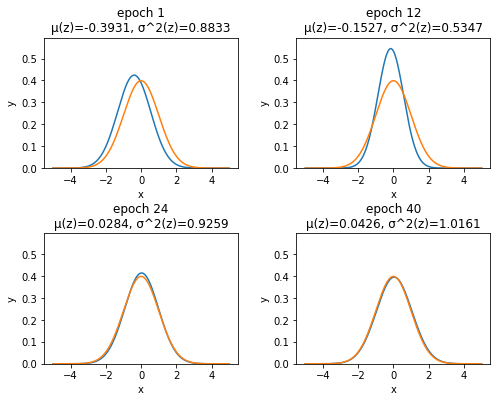

In [51]:
# Plotting histogram of the latent space's distribution, given the computed \mu and \sigma
if solver.epochs >= 16:
    plot_gaussian_distributions(solver)

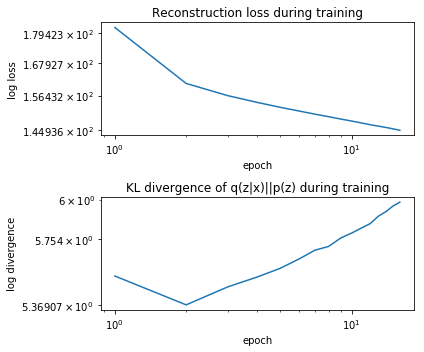

In [84]:
# Monitoring the reconstruction loss (likelihood lower bound) and KL divergence
DEBUG = 0
if solver.test_loss_history and DEBUG:
    for epoch, train_loss, test_loss, rl, kl in zip(solver.train_loss_history["epochs"], \
                             solver.train_loss_history["train_loss_acc"], \
                             solver.test_loss_history, \
                             solver.train_loss_history["recon_loss_acc"], \
                             solver.train_loss_history["kl_diverg_acc"]):
        print("epoch: {}, train_loss: {:.2f}, test_loss: {:.2f}, recon. loss: {:.2f}, KL div.: {:.2f}".format(
            epoch, train_loss, test_loss, rl, kl))
        print("overfitting: {:.2f}".format(abs(test_loss-train_loss)))
elif not(solver.test_loss_history) and DEBUG:
    for epoch, train_loss, rl, kl in zip(solver.train_loss_history["epochs"], \
                             solver.train_loss_history["train_loss_acc"], \
                             solver.train_loss_history["recon_loss_acc"], \
                             solver.train_loss_history["kl_diverg_acc"]):
        print("epoch: {}, train_loss: {:.2f}, recon. loss: {:.2f}, KL div.: {:.2f}".format(epoch, train_loss, rl, kl))
plot_rl_kl(solver)

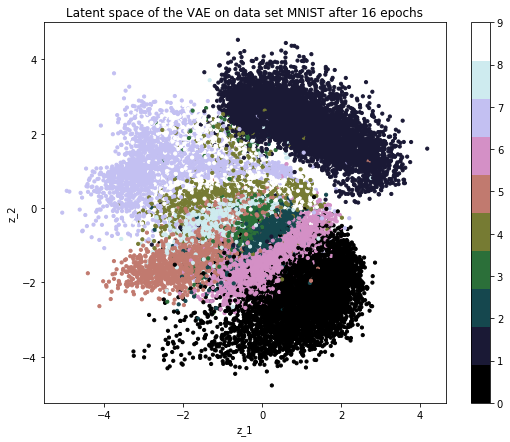

In [85]:
# visualize q(z|x) (latent space z)
if solver.z_dim == 2:
    if solver.loader.dataset != "FF":
        plot_latent_space(solver)
    else:
        plot_latent_space_no_labels(solver)
else:
    print("Plot of latent space not possible as dimension of z is not 2")

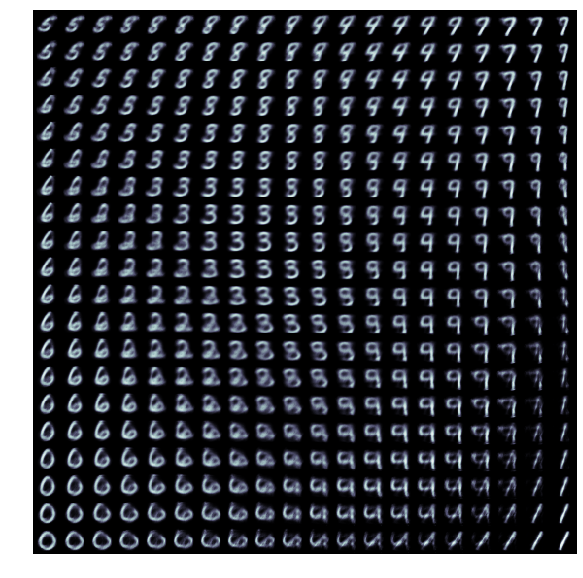

In [86]:
# Visualizations of learned data manifold for generative models with two-dimensional latent space
if solver.z_dim == 2:
    if solver.loader.dataset == "MNIST":
        plot_latent_manifold(solver, "bone")
    if solver.loader.dataset == "LFW" or solver.loader.dataset == "FF":
        plot_latent_manifold(solver, "gray", n=10, fig_size=(10,8))
else:
    print("Plot is not possible as dimension of z is not 2")

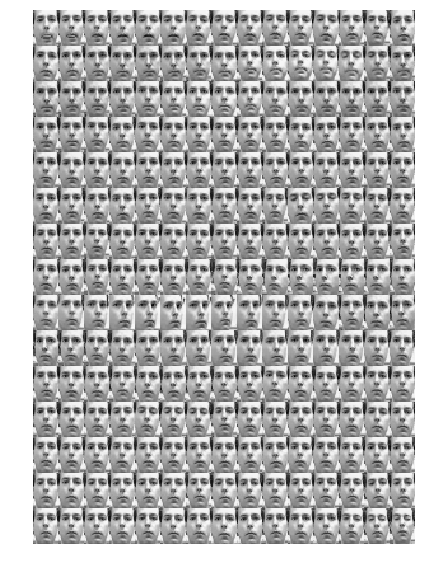

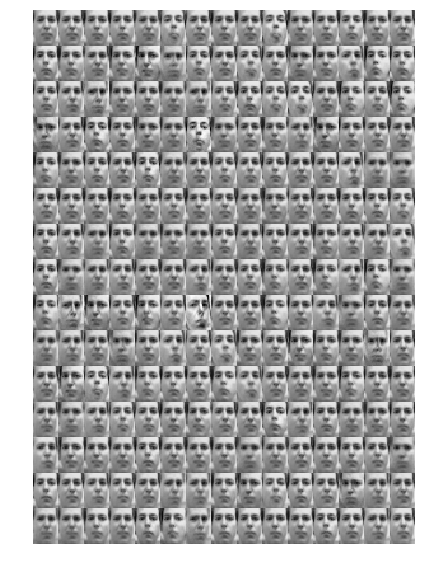

In [71]:
# plots real faces and in grid samples
if dataset == "LFW" or dataset == "FF":
    plot_faces_grid(225, 15, solver)
    plot_faces_samples_grid(225, 15, solver)

In [13]:
avg_train_loss = np.array(solver.train_loss_history["train_loss_acc"]).mean()
torch.save(solver, "../models/VAE_" + solver.loader.dataset + "_train_loss=" + "{0:.2f}".format(avg_train_loss) + "_z=" + str(solver.z_dim) + ".pt")